### Step One: Segmentation Experimentation
The below cells contain various experiements with image loading, processing, filtering, and edge-detecting.
This was my process to try and obtain better segmentation results with a single example image before compiling the best methods to apply to the full set.

In [3]:
%pip install pydicom
%pip install ipyfilechooser
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


In [4]:
from ipyfilechooser import FileChooser
import os
import re
import pandas as pd
import pydicom

def chooseFile(dataBaseDir):
    # Initialize file chooser widget and display
    fc = FileChooser(dataBaseDir)
    display(fc)
    return fc

def getData(fc, csv_data): 
    result = {}
    if fc.selected != None:
        # Current selection of the file chooser widget
        abs_path = fc.selected
        
        # Get the relative path of the file with the current working directory
        current_dir = os.getcwd()
        result['rel_path'] = os.path.relpath(abs_path, current_dir)
        
        # Read the dicom file using pydicom
        result['dicom_file'] = pydicom.read_file(abs_path)
        
        # Extract any (possibly) useful data from the file path
        parts = abs_path.split('_')
        result['patient_id'] = parts[2]
        result['laterality'] = parts[3]
        image_view_isolated = re.split(r'[_\\]+', parts[4])
        result['image_view'] = image_view_isolated[0]
        
        # Locate the associated row in the mass_test_description CSVfile
        filtered_csv_data = csv_data[(csv_data['patient_id'] == 'P_' + result['patient_id']) 
                                     & (csv_data['left or right breast'] == result['laterality'])
                                     & (csv_data['image view'] == result['image_view'])]
        
        # Print all data that has been located
        print('Associated data found in CSV file:')
        print(filtered_csv_data.to_string(index=False, columns=['patient_id', 'breast_density', 'left or right breast', 'image view', 'abnormality id', 'abnormality type']))
        
        print('\nAssociated data found in DICOM Metadata:')
        print(result['dicom_file'])
        
        
        return result
    return result

In [5]:
# Base directory for image folders
dataBaseDir = 'MassImages'
# Name of associated CSV file for more data
csv_filename = 'mass_case_description_test_set.csv'

# Read CSV data
csv_data = pd.read_csv(os.path.join(dataBaseDir, csv_filename))
# Choose a file. NOTE: Once this cell block has been run, be sure to select a .dcm file before proceeding to the next cell
fc = chooseFile(dataBaseDir)

FileChooser(path='C:\Workspace\BMEN509\BMEN509-FinalProject\MassImages', filename='', title='', show_hidden=Fa…

In [7]:
# Get data based on file selection
data = getData(fc, csv_data)

RefDs = data['dicom_file']

Associated data found in CSV file:
patient_id  breast_density left or right breast image view  abnormality id abnormality type
   P_00016               4                 LEFT         CC               1             mass

Associated data found in DICOM Metadata:
Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.255536750111234655207151937412512488011
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID  

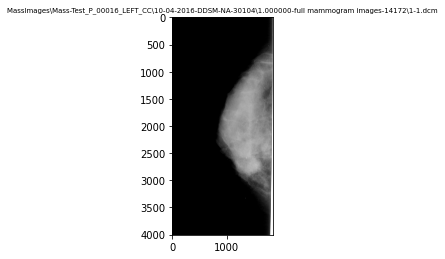

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# To obtain the dimensions of the array to store the image we will use the metadata
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))

# Then initialize in zeros an array
image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)

# Finally we had already read the file and we have the image information in the pixel_array (final field)
image[:,:]=RefDs.pixel_array

plt.title(data['rel_path'], fontsize=7)
plt.imshow(image, plt.cm.gray)

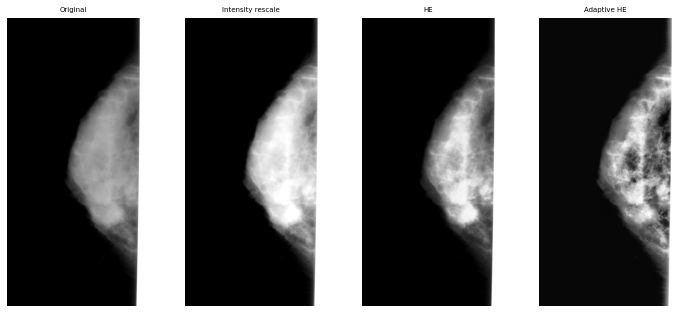

In [9]:
# https://scikit-image.org/docs/stable/auto_examples/color_exposure/plot_equalize.html
# image processing to prepare for edge detection
from skimage import exposure

# Contrast stretching
p2, p98 = np.percentile(image, (2, 98))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

# Equalization
image_eq = exposure.equalize_hist(image)

# Adaptive Equalization
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)

plt.subplots(1, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(141)
plt.grid(False)
plt.axis('off')
plt.title("Original", fontsize=7)
plt.imshow(image, plt.cm.gray)

plt.subplot(142)
plt.grid(False)
plt.axis('off')
plt.title("Intensity rescale", fontsize=7)
plt.imshow(image_rescale, plt.cm.gray)

plt.subplot(143)
plt.grid(False)
plt.axis('off')
plt.title("HE", fontsize=7)
plt.imshow(image_eq, plt.cm.gray)

plt.subplot(144)
plt.grid(False)
plt.axis('off')
plt.title("Adaptive HE", fontsize=7)
plt.imshow(image_adapteq, plt.cm.gray)
plt.show()

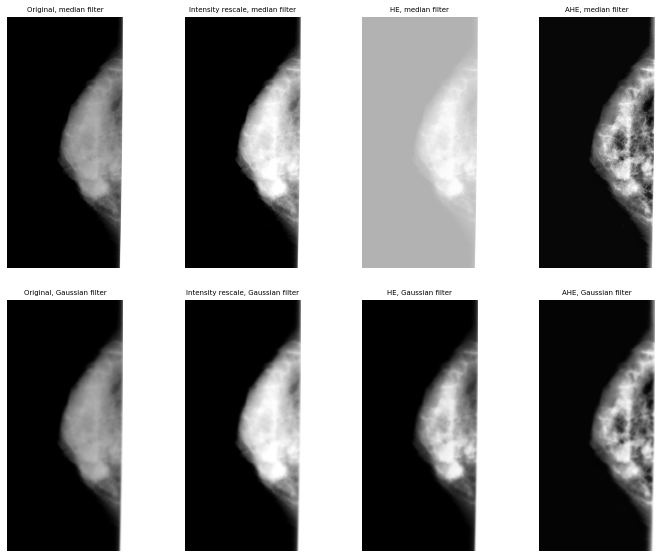

In [10]:
# smooth...
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter

images = [image, image_rescale, image_eq, image_adapteq]
images_med = [medfilt(image, 5) for image in images]
images_gaussian = [gaussian_filter(image, sigma=12) for image in images]

plt.subplots(2, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(241)
plt.title("Original, median filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_med[0], plt.cm.gray)

plt.subplot(242)
plt.title("Intensity rescale, median filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_med[1], plt.cm.gray)

plt.subplot(243)
plt.title("HE, median filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_med[2], plt.cm.gray)

plt.subplot(244)
plt.title("AHE, median filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_med[3], plt.cm.gray)

plt.subplot(245)
plt.title("Original, Gaussian filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_gaussian[0], plt.cm.gray)

plt.subplot(246)
plt.title("Intensity rescale, Gaussian filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_gaussian[1], plt.cm.gray)

plt.subplot(247)
plt.title("HE, Gaussian filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_gaussian[2], plt.cm.gray)

plt.subplot(248)
plt.title("AHE, Gaussian filter", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_gaussian[3], plt.cm.gray)

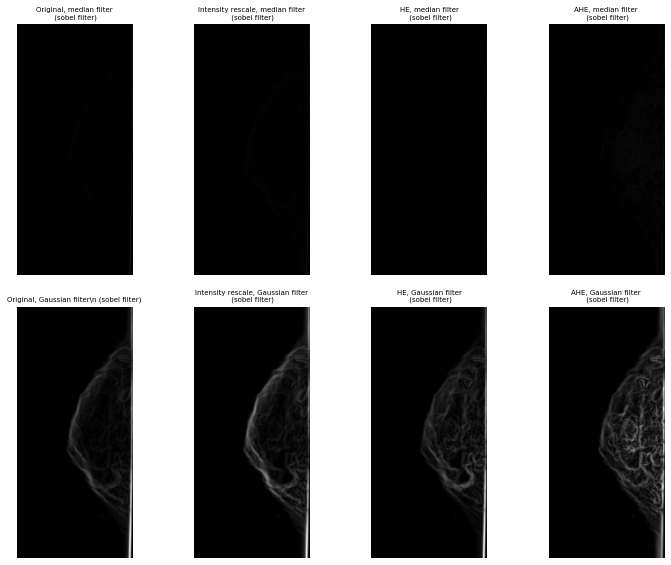

In [11]:
# get edges with Sobel
from skimage.filters import sobel

images = [image for image in images_med] + [image for image in images_gaussian]
images_sobel = [sobel(image) for image in images]

plt.subplots(2, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(241)
plt.title("Original, median filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[0], plt.cm.gray)

plt.subplot(242)
plt.title("Intensity rescale, median filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[1], plt.cm.gray)

plt.subplot(243)
plt.title("HE, median filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[2], plt.cm.gray)

plt.subplot(244)
plt.title("AHE, median filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[3], plt.cm.gray)

plt.subplot(245)
plt.title("Original, Gaussian filter\\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[4], plt.cm.gray)

plt.subplot(246)
plt.title("Intensity rescale, Gaussian filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[5], plt.cm.gray)

plt.subplot(247)
plt.title("HE, Gaussian filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[6], plt.cm.gray)

plt.subplot(248)
plt.title("AHE, Gaussian filter\n (sobel filter)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_sobel[7], plt.cm.gray)

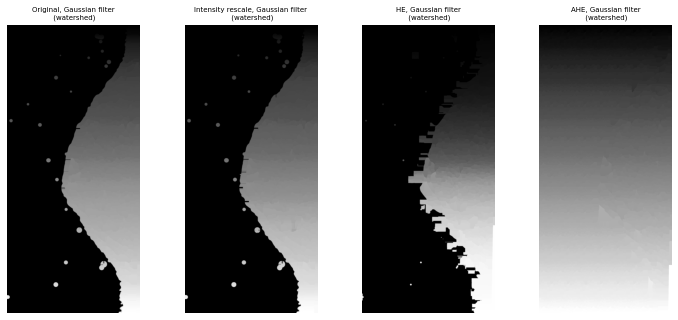

In [12]:
# watershed segmentation
from skimage import segmentation

images = [image for image in images_sobel[4:]] # only take gaussian filtered sobel
images_watershed_segmented = [segmentation.watershed(image) for image in images]

plt.subplots(1, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(141)
plt.title("Original, Gaussian filter\n (watershed)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_watershed_segmented[0], plt.cm.gray)

plt.subplot(142)
plt.title("Intensity rescale, Gaussian filter\n (watershed)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_watershed_segmented[1], plt.cm.gray)

plt.subplot(143)
plt.title("HE, Gaussian filter\n (watershed)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_watershed_segmented[2], plt.cm.gray)

plt.subplot(144)
plt.title("AHE, Gaussian filter\n (watershed)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_watershed_segmented[3], plt.cm.gray)

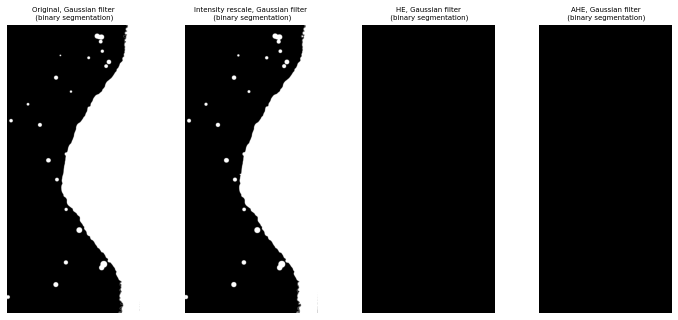

In [13]:
# binary segmentation
from scipy import ndimage as ndi

images = images_sobel[4:] # only take gaussian filtered sobel
images_binary_segmented = [ndi.binary_fill_holes(image) for image in images]

plt.subplots(1, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(141)
plt.title("Original, Gaussian filter\n (binary segmentation)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_binary_segmented[0], plt.cm.gray)

plt.subplot(142)
plt.title("Intensity rescale, Gaussian filter\n (binary segmentation)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_binary_segmented[1], plt.cm.gray)

plt.subplot(143)
plt.title("HE, Gaussian filter\n (binary segmentation)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_binary_segmented[2], plt.cm.gray)

plt.subplot(144)
plt.title("AHE, Gaussian filter\n (binary segmentation)", fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(images_binary_segmented[3], plt.cm.gray)

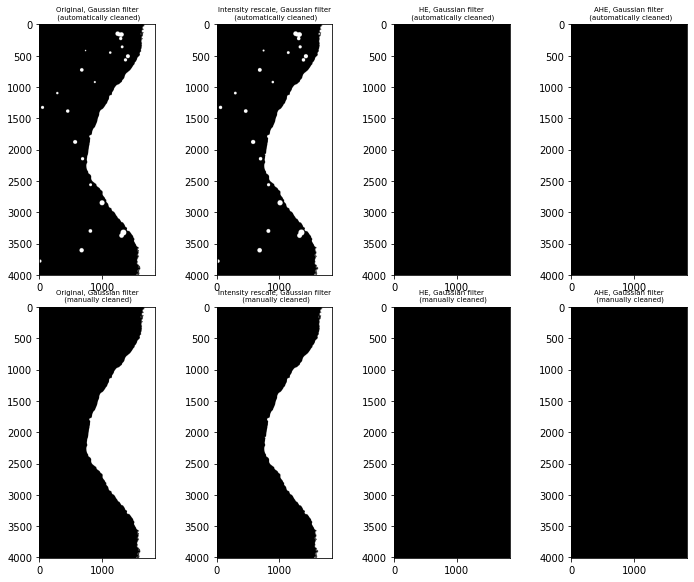

In [14]:
# clean up
from skimage import morphology
import cv2

# auto remove small objects
images = images_binary_segmented
images_auto_cleaned = [morphology.remove_small_objects(image, 21) for image in images]

# remove manually based on size of regions
def histogram_based_cleaning(image):
    mask = np.array(image, dtype='uint8')
    ret, markers = cv2.connectedComponents(mask) 
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret]) # get histogram on regions based on # pixels
    inxhist=np.argsort(hist)
    inxbone=inxhist[-2]
    ROI=np.zeros_like(image,'uint8')
    ROI[np.where(markers==inxbone)]=1
    return ROI

images_man_cleaned = [histogram_based_cleaning(image) for image in images]

plt.subplots(2, 4, figsize=(10,8))
plt.tight_layout()

plt.subplot(241)
plt.title("Original, Gaussian filter\n (automatically cleaned)", fontsize=7)
plt.imshow(images_auto_cleaned[0], plt.cm.gray)

plt.subplot(242)
plt.title("Intensity rescale, Gaussian filter\n (automatically cleaned)", fontsize=7)
plt.imshow(images_auto_cleaned[1], plt.cm.gray)

plt.subplot(243)
plt.title("HE, Gaussian filter\n (automatically cleaned)", fontsize=7)
plt.imshow(images_auto_cleaned[2], plt.cm.gray)

plt.subplot(244)
plt.title("AHE, Gaussian filter\n (automatically cleaned)", fontsize=7)
plt.imshow(images_auto_cleaned[3], plt.cm.gray)

plt.subplot(245)
plt.title("Original, Gaussian filter\n (manually cleaned)", fontsize=7)
plt.imshow(images_man_cleaned[0], plt.cm.gray)

plt.subplot(246)
plt.title("Intensity rescale, Gaussian filter\n (manually cleaned)", fontsize=7)
plt.imshow(images_man_cleaned[1], plt.cm.gray)

plt.subplot(247)
plt.title("HE, Gaussian filter\n (manually cleaned)", fontsize=7)
plt.imshow(images_man_cleaned[2], plt.cm.gray)

plt.subplot(248)
plt.title("AHE, Gaussian filter\n (manually cleaned)", fontsize=7)
plt.imshow(images_man_cleaned[3], plt.cm.gray)

#### Results
My results from step one are a collection of techniques that I think work the best for this segmentation method.

**Processing**  
I performed 3 different processing techniques: intensity rescaling, histogram equalization, and adaptive histogram equalization. I conclude that intensity rescaling has the most promising effect on emphasizing the tumour.

**Filtering**  
I performed 2 different filtering techniques to smooth the image: median and Gaussian. My intention with this step was to smooth away some of the fine details before edge detection to increase the chances of the tumour being one of the main features outlined. I conclude that the Gaussian filter did the best job here because details are eliminated, but not to the extent where all the edges are gone.

**Edge Detection**  
I performed 2 different edge detection functions: sobel and canny. The canny filter did not work at all; the whole image turned black. Therefore these images were removed. I conclude that the sobel filter is the better choice.

**Segmentation**  
I performed 2 different segmentation techniques: binary and watershed. The binary segmentation was only able to select the entire breast in the image; nothing more detailed such as a tumour showed. The watershed was able to pick-up a detailed object within the breast that could be the tumour. I conclude that the watershed algorithm is best.

**Clean Up**  
I performed 2 different cleanup techiques: automatic and histogram based. However, neither worked on the watershed algorithm images, so neither will be necessary,

Overall, the final segmentation results for my example image are not promising. From the data set description, we know this image contains a malignant tumour. However, instead of the tumour being detected, the whole breast was the only object I could extract. This leads me to think edge-based segmentation may not be the best for this application; the breast image is too detailed and contains too many edges for the tumour to be extracted. But first, let's see how our results from the full data set look.

### Step Two: Apply Segmentation
I will now apply my most successful techniques to the whole dataset and print the results.

In [15]:
import glob

root_dir = "./MassImages/"
key = "full mammogram images"

all_files = glob.glob("MassImages/**/*.dcm", recursive=True)
filenames = [file for file in all_files if key in file]

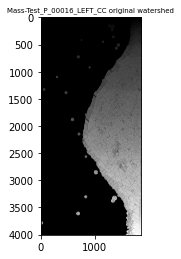

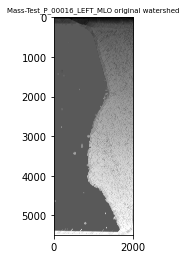

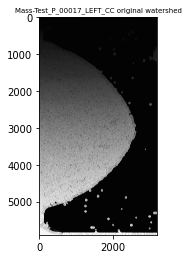

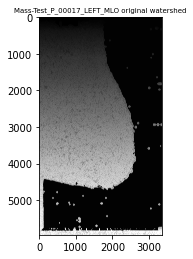

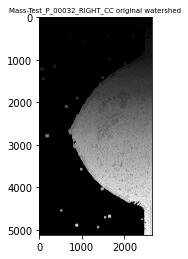

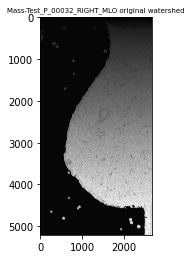

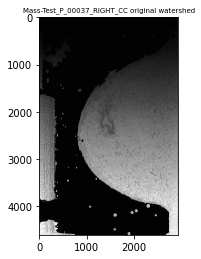

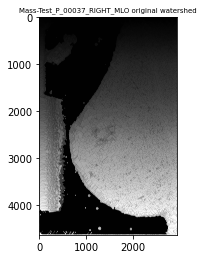

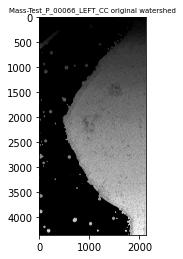

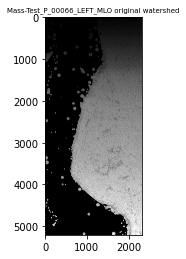

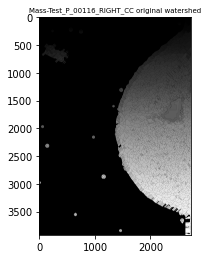

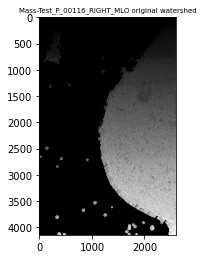

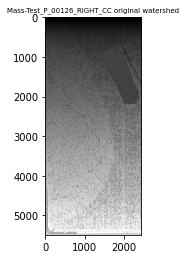

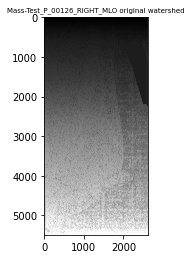

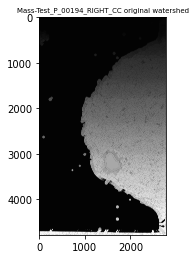

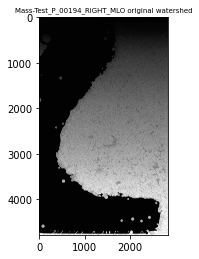

In [16]:
import numpy as np
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
from skimage import segmentation
import pydicom
import matplotlib.pyplot as plt

images_watershed = []

def edge_based_segmentation(filename):
    # Load image
    RefDs = pydicom.read_file(filename)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
    image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    image[:,:]=RefDs.pixel_array

    # Intensity rescaling
    p2, p98 = np.percentile(image, (2, 98))
    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

    # Gaussian filter
    image_gaussian = gaussian_filter(image_rescale, sigma=12)

    # Sobel edge detection
    image_sobel = sobel(image_gaussian)

    # Watershed segmentation
    image_watershed = segmentation.watershed(image_sobel, watershed_line=True)
    images_watershed.append(image_watershed)
    
    # Display
    display_name = filename.split('\\')[1]
    plt.title(display_name + " original watershed", fontsize=7)
    plt.imshow(image_watershed, plt.cm.gray)
    plt.show()

# get sample files
# filenames = ["MassImages\\Mass-Test_P_00037_RIGHT_CC\\10-04-2016-DDSM-NA-74559\\1.000000-full mammogram images-82316\\1-1.dcm", "MassImages\\Mass-Test_P_00066_LEFT_MLO\\10-04-2016-DDSM-NA-98300\\1.000000-full mammogram images-90349\\1-1.dcm", "MassImages\\Mass-Test_P_00116_RIGHT_MLO\\10-04-2016-DDSM-NA-99311\\1.000000-full mammogram images-87253\\1-1.dcm", "MassImages\\Mass-Test_P_00194_RIGHT_CC\\10-04-2016-DDSM-NA-52705\\1.000000-full mammogram images-16033\\1-1.dcm"]
# filenames = ["MassImages\\Mass-Test_P_00194_RIGHT_CC\\10-04-2016-DDSM-NA-52705\\1.000000-full mammogram images-16033\\1-1.dcm"]

for file in filenames:
    edge_based_segmentation(file)

### Results
As predicted from step one, the results from edge-based segmentation so far are mediocre. It is not clear whether the tumours are being segmented properly yet; we'll need to calculate the DICE coefficient to get quantifiable results. When observing the results with my naked eye, I can see some distinguishable region that may be a tumour in some of the results. However, there is not always one of these regions in images that contain malignant tumours.

### Next Steps
Next, I will find a way to extract the tumour region from the results to get a mask that we can compare to the true mask, allowing us to calculate the DICE coefficient.


### Step Three: Masking Experimentation

* First: hard-coded values
* Second: percentage
* Third: try every 1-percent range and keep the largest result


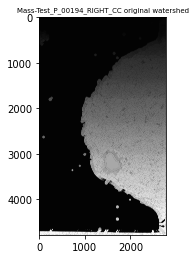

In [17]:
import numpy as np
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
from skimage import segmentation
import pydicom
import matplotlib.pyplot as plt

# filename = "MassImages\\Mass-Test_P_00116_RIGHT_MLO\\10-04-2016-DDSM-NA-99311\\1.000000-full mammogram images-87253\\1-1.dcm"
filename = "MassImages\\Mass-Test_P_00194_RIGHT_CC\\10-04-2016-DDSM-NA-52705\\1.000000-full mammogram images-16033\\1-1.dcm"
# filename = "MassImages\\Mass-Test_P_00066_LEFT_MLO\\10-04-2016-DDSM-NA-98300\\1.000000-full mammogram images-90349\\1-1.dcm"

RefDs = pydicom.read_file(filename)
ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
image[:,:]=RefDs.pixel_array

# Intensity rescaling
p2, p98 = np.percentile(image, (2, 98))
image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))

# Gaussian filter
image_gaussian = gaussian_filter(image_rescale, sigma=12)

# Sobel edge detection
image_sobel = sobel(image_gaussian)

# Watershed segmentation
image_watershed = segmentation.watershed(image_sobel, watershed_line=True)

# Display
display_name = filename.split('\\')[1]
plt.title(display_name + " original watershed", fontsize=7)
plt.imshow(image_watershed, plt.cm.gray)
plt.show()

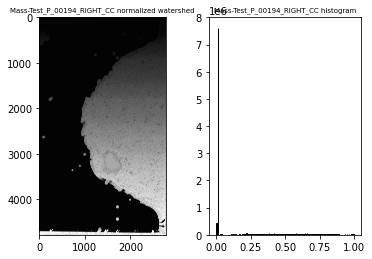

In [18]:
# Normalization
import cv2

# Normalize the image
image_normalized = cv2.normalize(image_watershed, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Display
plt.subplots(1, 2)
plt.subplot(121)
plt.title(display_name + " normalized watershed", fontsize=7)
plt.imshow(image_normalized, plt.cm.gray)

plt.subplot(122)
plt.hist(image_normalized.ravel(), bins=256, range=(0.0, 1.0), fc='k', ec='k') #calculating histogram
plt.title(display_name + " histogram", fontsize=7)
plt.show()

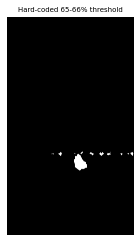

In [19]:
# Threshold masking
colour_max = np.max(image_normalized)
# 194 RCC:
lower_threshold_percentage = 0.65
upper_threshold_percentage = 0.66
# 37 RCC:
# lower_threshold_percentage = 0.39
# upper_threshold_percentage = 0.40
# 66 LMLO:
# lower_threshold_percentage = 0.70
# upper_threshold_percentage = 0.71
# 116 LMLO:
# lower_threshold_percentage = 0.23
# upper_threshold_percentage = 0.24
mask = np.zeros_like(image_normalized,'uint8')
mask[image_normalized > lower_threshold_percentage*colour_max] = 1 
mask[image_normalized > upper_threshold_percentage*colour_max] = 0 
plt.title("Hard-coded 65-66% threshold", fontsize=7)
plt.imshow(mask, plt.cm.gray)
plt.grid(False)
plt.axis('off')
plt.show()

13
64343


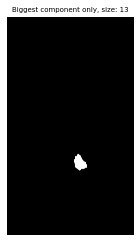

In [20]:
import cv2

# Get tumor mask
ret, markers = cv2.connectedComponents(mask) 
hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
inxhist=np.argsort(hist)
inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
print(inxhist[-2])
ROI=np.zeros_like(image_watershed,'uint8')
ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region
print(np.sum(ROI > 0)) # number of non-0 pixels

plt.title("Biggest component only, size: {}".format(inxhist[-2]), fontsize=7)
plt.grid(False)
plt.axis('off')
plt.imshow(ROI, plt.cm.gray)
plt.show()

#### Check-in
The current strategy is working well but a different threshold is required for each image. Let's try looping through every 1% range threshold possibility and choose the one that yields the largest mask.

In [21]:
# Loop through every 1% range and land on biggest option
def get_mask_size(image, lower_threshold_percentage):
    # print(lower_threshold_percentage, end="\r", flush=True)
    colour_max = np.max(image)
    upper_threshold_percentage = lower_threshold_percentage + 0.01
    mask = np.zeros_like(image,'uint8')
    mask[image > lower_threshold_percentage*colour_max] = 1 
    mask[image > upper_threshold_percentage*colour_max] = 0 
    ret, markers = cv2.connectedComponents(mask) 
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    inxhist=np.argsort(hist)
    if inxhist.size >= 2:
        return inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
    else:
        return 0

mask_sizes = {}
for i in range(0,100):
    lower_threshold_percentage = i/100
    mask_sizes[lower_threshold_percentage] = get_mask_size(image_normalized, lower_threshold_percentage)
    print(mask_sizes, end="\r", flush=True)

Max value key:  0.97


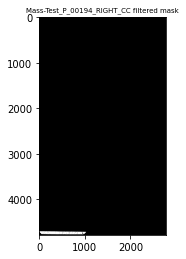

In [22]:
# use best low threshold value to generate mask
max_key = max(mask_sizes, key=mask_sizes.get)
print("Max value key: ", max_key)

# print max size mask
colour_max = np.max(image_normalized)
lower_threshold_percentage = max_key
upper_threshold_percentage = lower_threshold_percentage + 0.01
mask = np.zeros_like(image_normalized,'uint8')
mask[image_normalized > lower_threshold_percentage*colour_max] = 1 
mask[image_normalized > upper_threshold_percentage*colour_max] = 0 
ret, markers = cv2.connectedComponents(mask) 
hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
inxhist=np.argsort(hist)
inxbone=inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
ROI=np.zeros_like(image_normalized,'uint8')
ROI[np.where(markers==inxbone)]=1   #we turn to 1 only those pixels that are in that second most frequent region
plt.title(display_name + " filtered mask", fontsize=7)
plt.imshow(ROI, plt.cm.gray)
plt.show()

### Step Four: Apply Masking

In [23]:
# Loop through every 1% range and land on biggest option
def get_mask_size(image, lower_threshold_percentage):
    # print(lower_threshold_percentage, end="\r", flush=True)
    colour_max = np.max(image)
    upper_threshold_percentage = lower_threshold_percentage + 0.01
    mask = np.zeros_like(image,'uint8')
    mask[image > lower_threshold_percentage*colour_max] = 1 
    mask[image > upper_threshold_percentage*colour_max] = 0 
    ret, markers = cv2.connectedComponents(mask) 
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    inxhist=np.argsort(hist)
    if inxhist.size >= 2:
        return inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
    else:
        return 0

In [24]:
def get_best_lower_threshold(image):
    mask_sizes = {}
    for i in range(20,80):
        lower_threshold_percentage = i/100
        mask_sizes[lower_threshold_percentage] = get_mask_size(image, lower_threshold_percentage)
    return max(mask_sizes, key=mask_sizes.get)

Mass-Test_P_00016_LEFT_CC
0.45
5


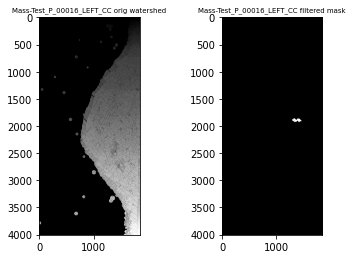

Mass-Test_P_00016_LEFT_MLO
0.29
38


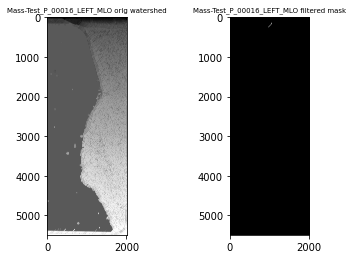

Mass-Test_P_00017_LEFT_CC
0.36
10


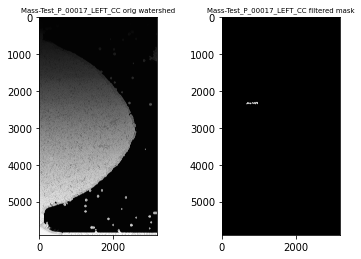

Mass-Test_P_00017_LEFT_MLO
0.51
7


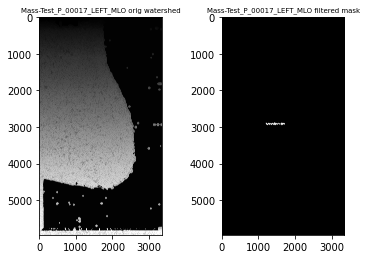

Mass-Test_P_00032_RIGHT_CC
0.55
8


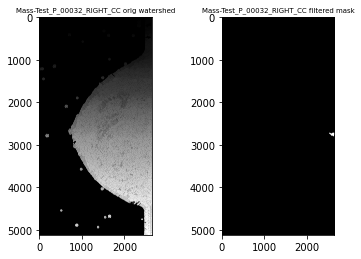

Mass-Test_P_00032_RIGHT_MLO
0.59
8


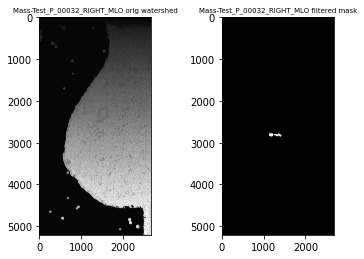

Mass-Test_P_00037_RIGHT_CC
0.39
16


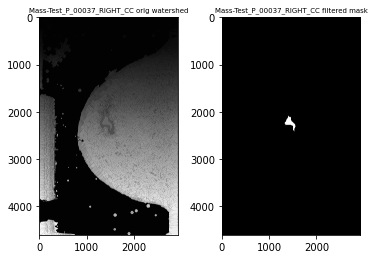

Mass-Test_P_00037_RIGHT_MLO
0.4
18


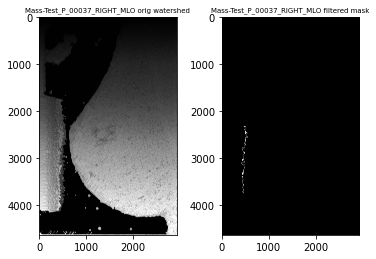

Mass-Test_P_00066_LEFT_CC
0.35
4


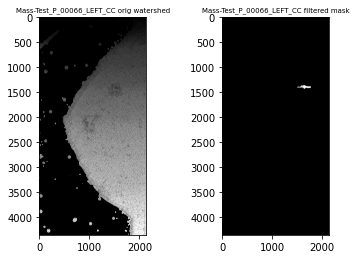

Mass-Test_P_00066_LEFT_MLO
0.37
6


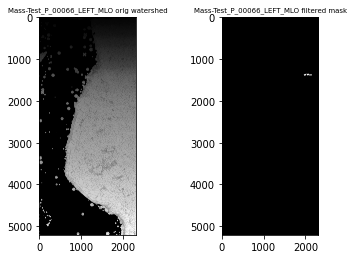

Mass-Test_P_00116_RIGHT_CC
0.36
11


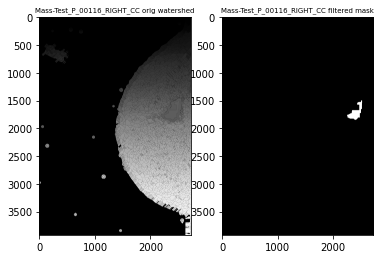

Mass-Test_P_00116_RIGHT_MLO
0.23
8


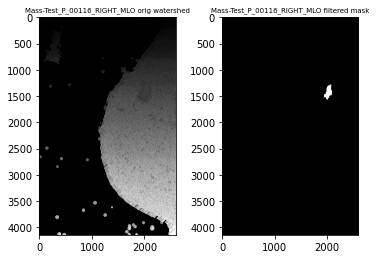

Mass-Test_P_00126_RIGHT_CC
0.23
8


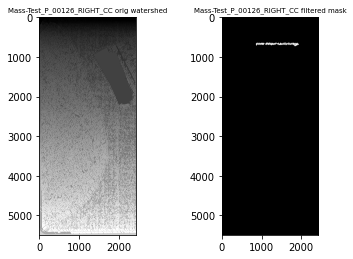

Mass-Test_P_00126_RIGHT_MLO
0.41
7


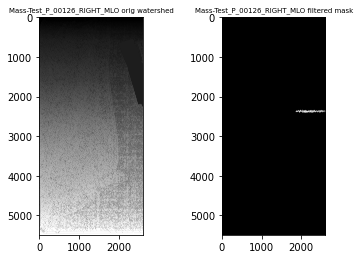

Mass-Test_P_00194_RIGHT_CC
0.65
13


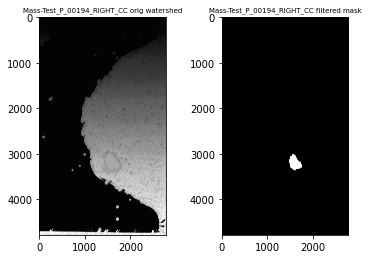

Mass-Test_P_00194_RIGHT_MLO
0.79
12


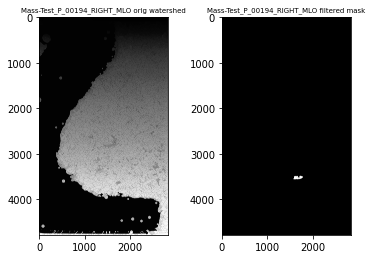

In [25]:
# Try with all images...
import numpy as np
import matplotlib.pyplot as plt
import cv2

def apply_tumour_mask(image, filename):
    display_name = filename.split('\\')[1]
    print(display_name)

    plt.subplots(1, 2)
    plt.subplot(121)
    plt.title(display_name + " orig watershed", fontsize=7)
    plt.imshow(image, plt.cm.gray)

    # Threshold masking
    colour_max = np.max(image)
    lower_threshold_percentage = get_best_lower_threshold(image)
    print(lower_threshold_percentage)
    upper_threshold_percentage = lower_threshold_percentage + 0.01
    mask = np.zeros_like(image,'uint8')
    mask[image > lower_threshold_percentage*colour_max] = 1 
    mask[image > upper_threshold_percentage*colour_max] = 0 

    # Get tumor mask
    ret, markers = cv2.connectedComponents(mask) 
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    inxhist=np.argsort(hist)
    inxbone=inxhist[-2]
    print(inxbone)
    cleaned_mask=np.zeros_like(image,'uint8')
    cleaned_mask[np.where(markers==inxbone)]=1
    plt.subplot(122)
    plt.title(display_name + " filtered mask", fontsize=7)
    plt.imshow(cleaned_mask, plt.cm.gray)
    plt.show()

for (image, filename) in zip(images_watershed, filenames):
    apply_tumour_mask(image, filename)

### Step 5: Compile Results

In [2]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pydicom

In [3]:
# Get filenames
import glob

key = "full mammogram images"

all_files = glob.glob("MassImages/**/*.dcm", recursive=True)
filenames = [file for file in all_files if key in file]
# filenames = filenames[0]
# filenames = ["MassImages\\Mass-Test_P_00194_RIGHT_CC\\10-04-2016-DDSM-NA-52705\\1.000000-full mammogram images-16033\\1-1.dcm"]

In [4]:
# Helpers
def update_progress(verb, idx, total):
    print((verb + " " + str(idx) + "/" + str(total)), end="\r", flush=True)

def load_image(filename):
    RefDs = pydicom.read_file(filename)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns))
    image = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    image[:,:]=RefDs.pixel_array
    return image

In [5]:
# Load images
images = []

for idx, filename in enumerate(filenames):
    images.append(load_image(filename))
    update_progress("Loaded", idx+1, len(filenames))

In [6]:
# Load true masks
mask_images = []

for idx, filename in enumerate(filenames):
    tokens = filename.split('\\')
    main_dir = tokens[0] + "/" + tokens[1]
    mask_filename = glob.glob(main_dir + "_1/**/*-2.dcm", recursive=True)
    mask_images.append(load_image(mask_filename[0]))
    update_progress("Loaded", idx+1, len(filenames))

In [7]:
# Get diagnoses
import pandas as pd

diagnoses = []

data = pd.read_csv("MassImages\mass_case_description_test_set.csv")

for filename in filenames:
    tokens = filename.split('\\')
    sub_tokens = tokens[1].split('_')
    patient_id = "P_" + sub_tokens[2]
    side = sub_tokens[3]
    view = sub_tokens[4]
    row = (data.loc[(data['patient_id'] == patient_id) & (data['left or right breast'] == side) & (data['image view'] == view)])
    diagnoses.append(row.iloc[0]['pathology'])
    update_progress("Found data for", idx+1, len(filenames))

In [9]:
# Segment
from skimage import exposure
from scipy.ndimage import gaussian_filter
from skimage.filters import sobel
from skimage import segmentation

images_watershed = []

def edge_based_segmentation(image):
    # Intensity rescaling
    p2, p98 = np.percentile(image, (2, 98))
    image_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))
    
    # Gaussian filter
    image_gaussian = gaussian_filter(image_rescale, sigma=12)

    # Sobel edge detection
    image_sobel = sobel(image_gaussian)

    # Watershed segmentation
    # image_watershed = segmentation.watershed(image_sobel, watershed_line=True)
    image_watershed = segmentation.watershed(image_sobel)
    images_watershed.append(image_watershed)

for idx, image in enumerate(images):
    edge_based_segmentation(image)
    update_progress("Segmented", idx+1, len(images))

In [10]:
# Generate masks
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.measure import regionprops, label
import matplotlib.patches as patches

masks = []

# Returns: (mask_width, mask_length)
def get_mask_size(image, lower_threshold_percentage):
    # Threshold image to given percentage
    colour_max = np.max(image)
    upper_threshold_percentage = lower_threshold_percentage + 0.01
    mask = np.zeros_like(image,'uint8')
    mask[image > lower_threshold_percentage*colour_max] = 1 
    mask[image > upper_threshold_percentage*colour_max] = 0 

    # Isolate 2nd most frequency component
    ret, markers = cv2.connectedComponents(mask) 
    hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
    inxhist=np.argsort(hist)

    # Get width and height of single component
    if inxhist.size < 2:
        return 0
    inxbone=inxhist[-2]
    cleaned_mask=np.zeros_like(image,'uint8')
    cleaned_mask[np.where(markers==inxbone)]=1
    labeled_mask = label(cleaned_mask)
    props = regionprops(labeled_mask)
    if len(props) == 1:
        prop = props[0]
        x = prop.bbox[1]
        y = prop.bbox[0]
        width = prop.bbox[3]-prop.bbox[1]
        height = prop.bbox[2]-prop.bbox[0]
        ## Start bounding box draw ##
        # fig, ax = plt.subplots()
        # ax.axis('off')
        # ax.imshow(cleaned_mask, plt.cm.gray)
        # rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor='none')
        # ax.add_patch(rect)
        # plt.show()
        ## End ##
        return (width, height)
    return (0, 0)

    ## Start histogram based ##
    # if inxhist.size >= 2:
    #     return inxhist[-2]  #this is the index of the second last region (the last being the most frequent)
    # else:
    #     return 0
    ## End ##

def get_most_square_mask(mask_dimensions):
    max_area = 0
    best_threshold = 0
    min_squareness_ratio = 1.3
    for key in mask_dimensions:
        mask_dimension = mask_dimensions[key]
        width = mask_dimension[0]
        height = mask_dimension[1]
        # print("{}: {} x {}".format(key, width, height))
        if np.min(mask_dimension)*min_squareness_ratio >= np.max(mask_dimension):
            # it's square enough!
            if width*height > max_area:
                # new best option found
                max_area = width * height
                best_threshold = key
    return best_threshold

def get_best_lower_threshold(image):
    mask_sizes = {}
    for i in range(20,80):
        lower_threshold_percentage = i/100
        mask_sizes[lower_threshold_percentage] = get_mask_size(image, lower_threshold_percentage) # get_mask_dimensions
    return get_most_square_mask(mask_sizes)
    # return max(mask_sizes, key=mask_sizes.get)

def apply_tumour_mask(image):
    # Threshold masking
    colour_max = np.max(image)
    lower_threshold_percentage = get_best_lower_threshold(image)
    if lower_threshold_percentage == 0: upper_threshold_percentage = 0 # No good mask found... don't set a mask
    else: upper_threshold_percentage = lower_threshold_percentage + 0.01
    mask = np.zeros_like(image,'uint8')
    mask[image > lower_threshold_percentage*colour_max] = 1 
    mask[image > upper_threshold_percentage*colour_max] = 0 

    # Get tumor mask
    cleaned_mask=np.zeros_like(image,'uint8')
    if lower_threshold_percentage != 0:
        ret, markers = cv2.connectedComponents(mask) 
        hist,bins = np.histogram(markers.flatten(),ret,[0,ret])
        inxhist=np.argsort(hist)
        inxbone=inxhist[-2]
        cleaned_mask[np.where(markers==inxbone)]=1
    masks.append(cleaned_mask)

for idx, image in enumerate(images_watershed):
    apply_tumour_mask(image)
    update_progress("Masked", idx+1, len(images_watershed))

In [11]:
# Calculate estimated tumour size
average_mammogram_pixel_area_micrometers = (0.07 ** 2) # https://www.ajronline.org/doi/full/10.2214/AJR.14.13126

def get_tumour_size(mask):
    num_non_0_pixels = np.sum(mask > 0)
    return num_non_0_pixels*average_mammogram_pixel_area_micrometers

In [12]:
# Calculate the DICE coefficient
# Takes two binary masks and compares the interesction between them. 
def dice_coefficient(mask1, mask2):
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2)
    dice = (2 * intersection) / union
    return dice

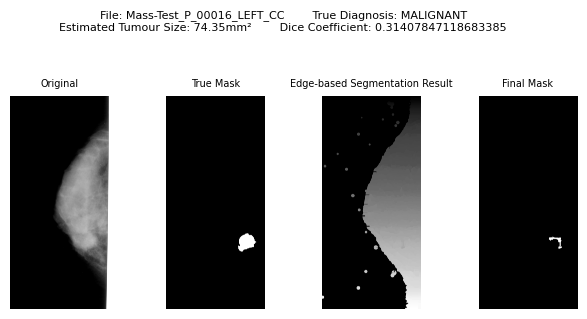

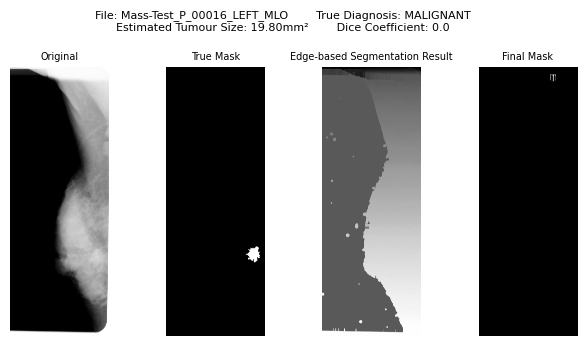

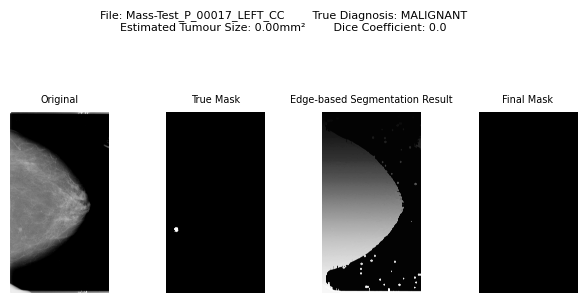

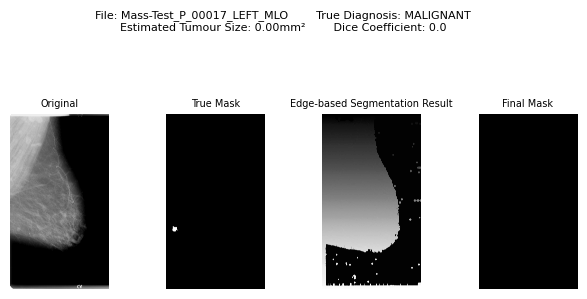

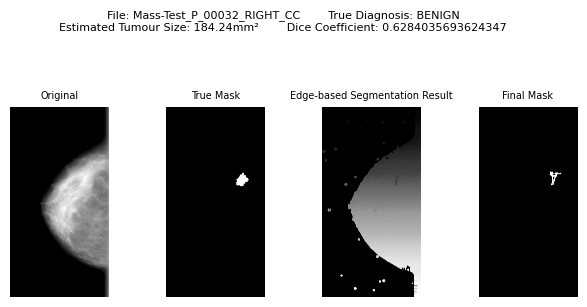

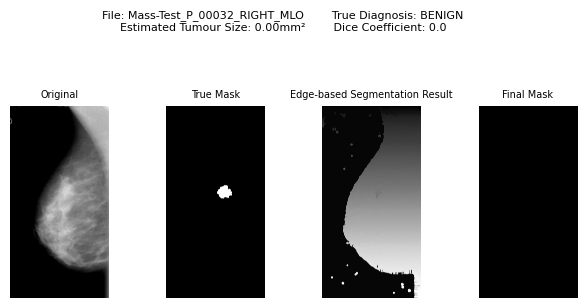

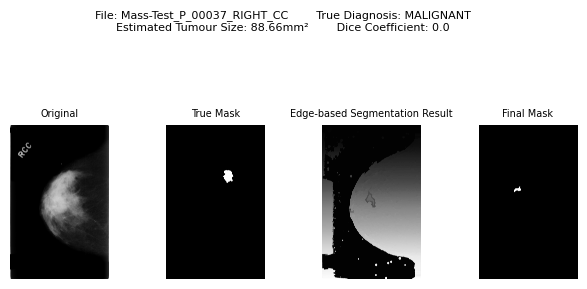

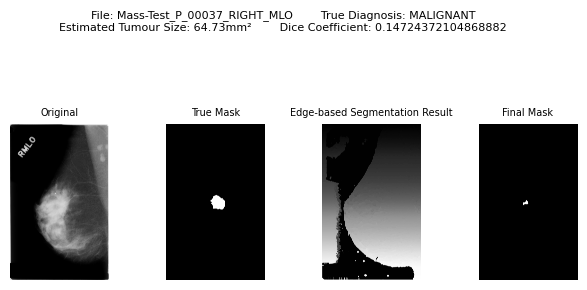

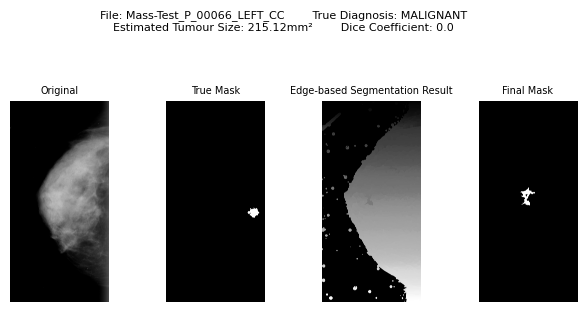

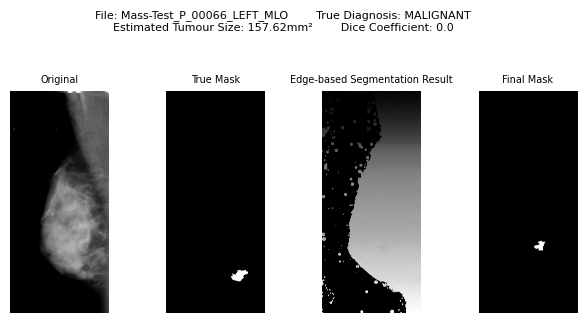

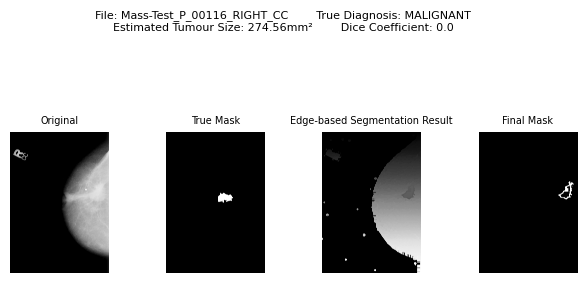

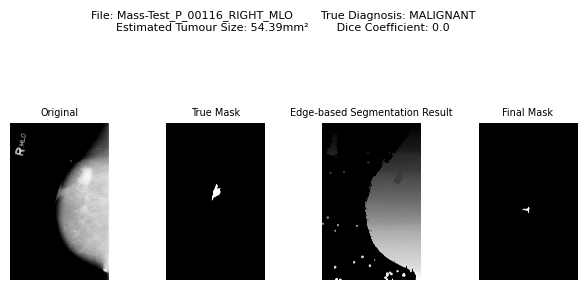

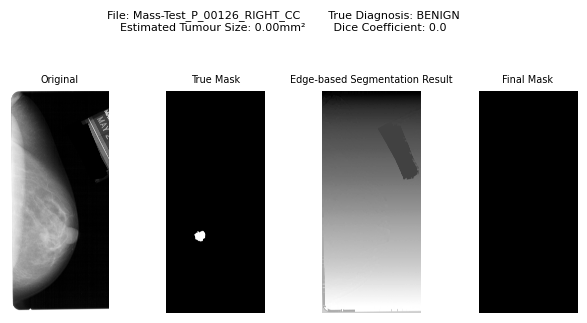

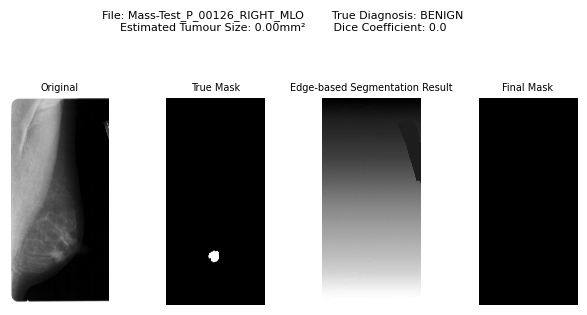

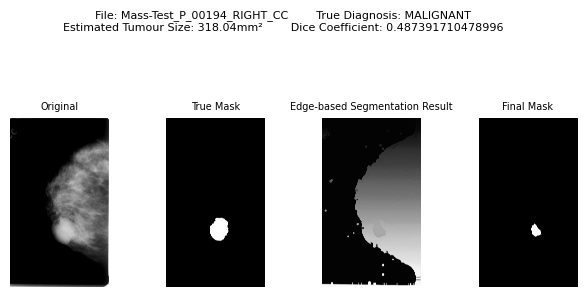

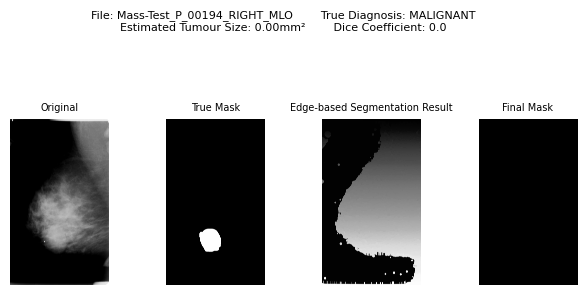

Average DICE Coefficient: 0.09856984200480959


In [23]:
# Display results
dice_scores = []
results_dir = 'EdgeDetectionResults\\'

def display_result(filename, diagnosis, original, true_mask, watershed, mask):
    display_name = filename.split('\\')[1]
    dice = dice_coefficient(true_mask, mask)
    dice_scores.append(dice)
    title = "File: " + display_name + "        True Diagnosis: " + diagnosis + "\nEstimated Tumour Size: " + "{:.2f}mm\u00b2".format(get_tumour_size(mask)) + "        Dice Coefficient: " + str(dice)
    plt.subplots(1, 4)
    plt.tight_layout()
    plt.suptitle(title, fontsize=8, y=0.92)

    plt.subplot(141)
    plt.title("Original", fontsize=7)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(original, plt.cm.gray)

    plt.subplot(142)
    plt.title("True Mask", fontsize=7)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(true_mask, plt.cm.gray)

    plt.subplot(143)
    plt.title("Edge-based Segmentation Result", fontsize=7)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(watershed, plt.cm.gray)

    plt.subplot(144)
    plt.title("Final Mask", fontsize=7)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(mask, plt.cm.gray)

    results_filename = filename.split('\\')[1]
    plt.savefig(results_dir + results_filename + '_result.png')
    plt.show()

for (filename, diagnosis, original, true_mask, watershed, mask) in zip(filenames, diagnoses, images, mask_images, images_watershed, masks):
    display_result(filename, diagnosis, original, true_mask, watershed, mask)
    total_files = len(filenames)

Average DICE Coefficient: 0.09856984200480959


[Text(0, 0, '12'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '1'),
 Text(0, 0, '0'),
 Text(0, 0, '0'),
 Text(0, 0, '0')]

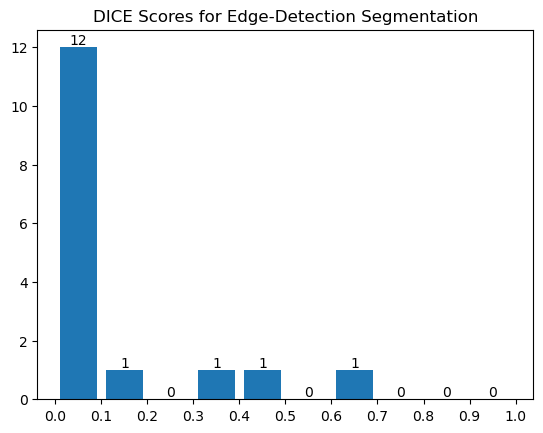

In [32]:
print("Average DICE Coefficient: " + str(sum(dice_scores)/total_files))
counts, bins = np.histogram(dice_scores, range=[0, 1.0], bins=10)
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.title("DICE Scores for Edge-Detection Segmentation")
counts, edges, bars = plt.hist(bins[:-1], bins, weights=counts, rwidth=0.8)
plt.bar_label(bars)